## Complex Seasonality

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(fable))
suppressMessages(library(tsibble))
suppressMessages(library(fabletools))
suppressMessages(library(feasts))
suppressMessages(library(lubridate))
suppressMessages(library(scales))
suppressMessages(library(fpp3))
suppressMessages(library(gridExtra))

plot_prefix <- 'plots/w12_'

### Bank Calls
Calls over a 5-minute period, potentially:
- Time of hour seasonality
- Time of day seasonality
- Day of week seasonality
- Monthly seasonality

In [2]:
bank_calls %>% head()

DateTime,Calls
<dttm>,<dbl>
2003-03-03 07:00:00,111
2003-03-03 07:05:00,113
2003-03-03 07:10:00,76
2003-03-03 07:15:00,82
2003-03-03 07:20:00,91
2003-03-03 07:25:00,87


This is interesting since it only includes days where the bank was open to receive calls, so you'll need to fill the gaps to plot it accurately.

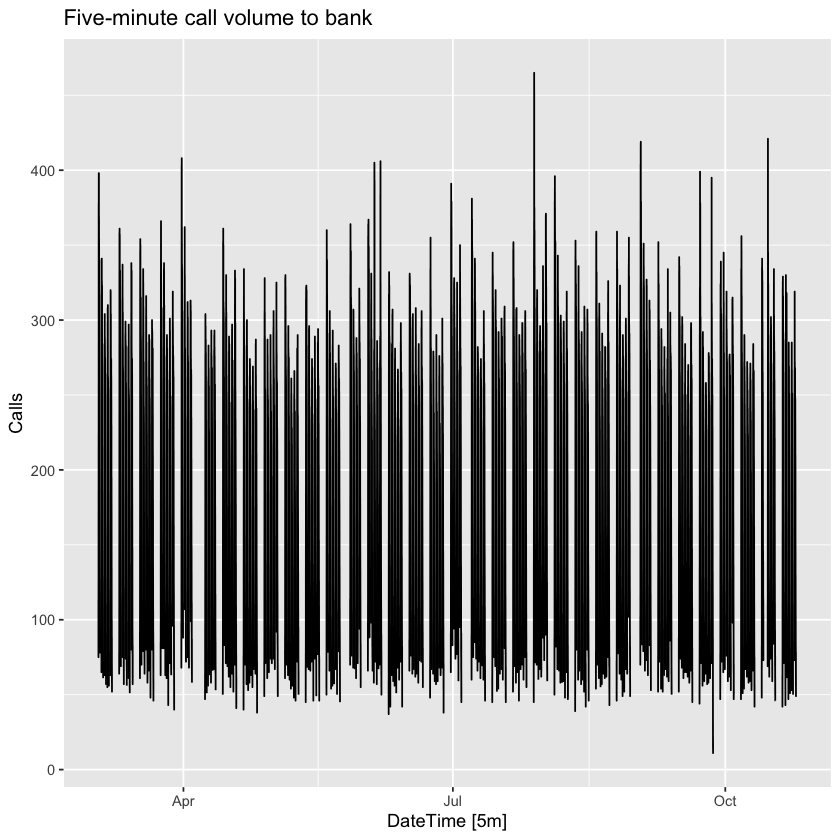

In [3]:
bank_calls |>
  fill_gaps() |>
  autoplot(Calls) +
  labs(y = "Calls", title = "Five-minute call volume to bank")

ggsave(paste(plot_prefix, 'bank_calls.png', sep=''), height = 4, width = 6)

Different Hourly Patterns by Day of the Week

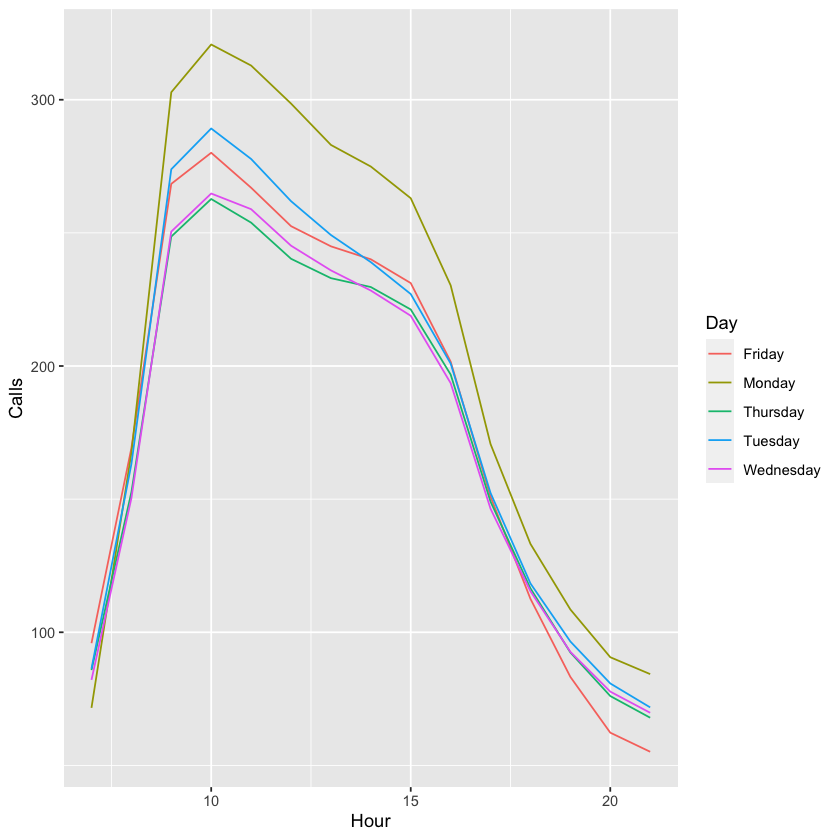

In [4]:
bank_calls %>%
mutate(Hour = hour(DateTime), Day = weekdays(DateTime)) %>%
ggplot(aes(x=Hour, y=Calls, colour=Day, group=Day)) + 
stat_summary(fun = mean, geom = "line")

ggsave(paste(plot_prefix, 'bank_calls_hourly.png'), height = 5, width = 5)

Warning message:
"Removed 36 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 36 rows containing missing values (`geom_line()`)."


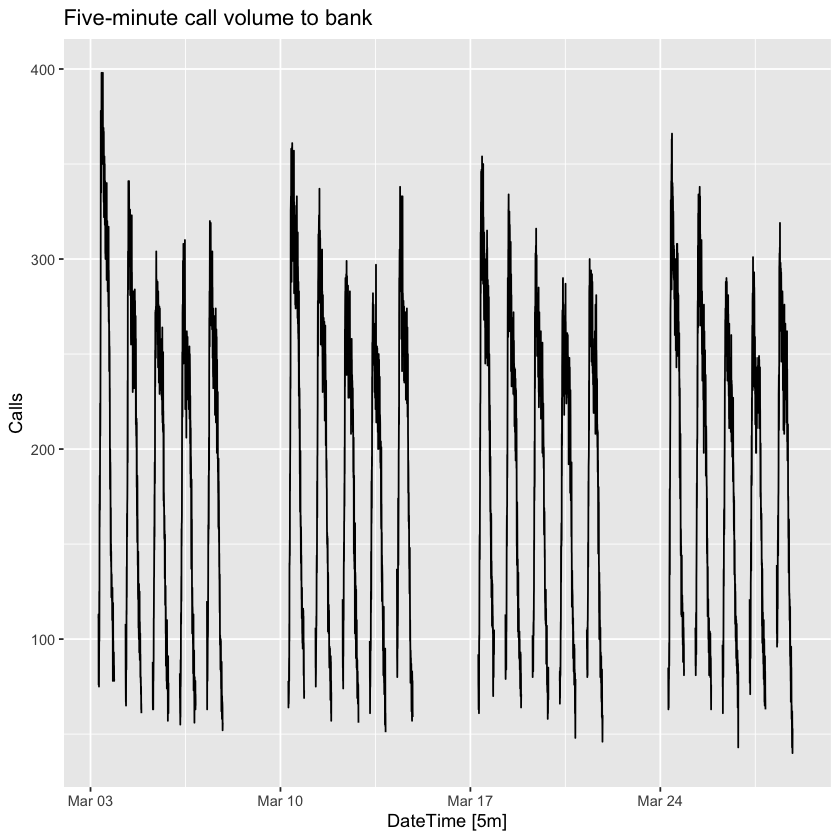

In [5]:
bank_calls |>
  fill_gaps() |>
  filter(DateTime <= as.Date('2003-03-29')) |>
  autoplot(Calls) +
  labs(y = "Calls",
       title = "Five-minute call volume to bank")

ggsave(paste(plot_prefix, 'bank_calls_daily.png', sep=''), height = 5, width = 5)

#### STL Decomposition
Reindexing the tibble to avoid missing values because of the weekends and holidays. In practice you could either add those back in after the fact or in may not matter.

Seasonal period is **169**, which equals the number of 5 minute intervals, second seasonal period for days of the week.

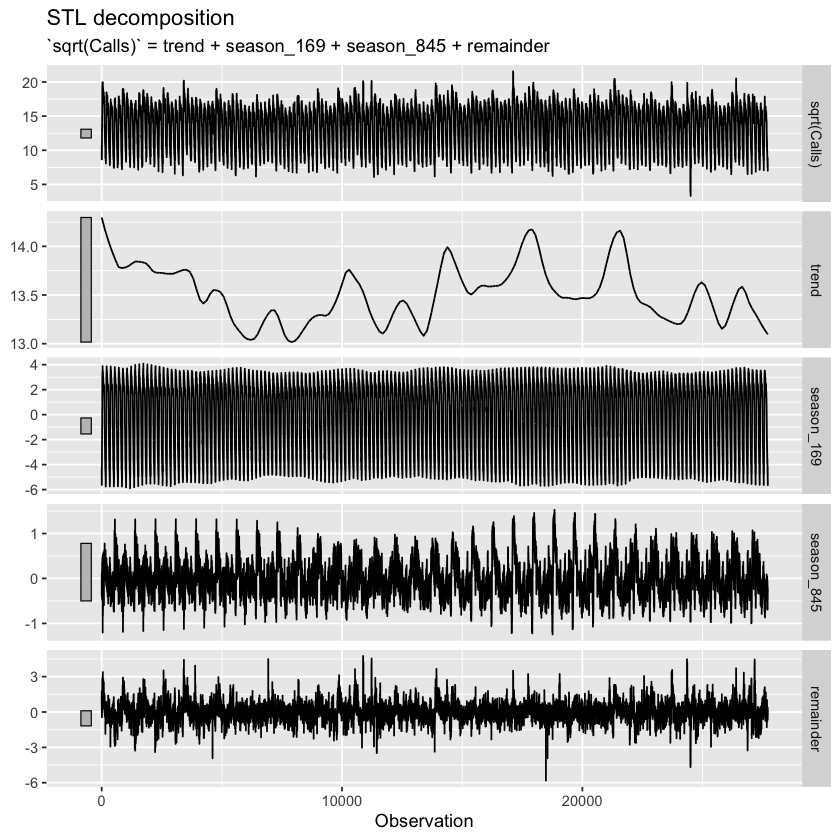

In [6]:
calls <- bank_calls |>
  mutate(t = row_number()) |>
  update_tsibble(index = t, regular = TRUE)

calls |>
  model(
    STL(sqrt(Calls) ~ season(period = 169) +
                      season(period = 5*169),
        robust = TRUE)
  ) |>
  components() |>
  autoplot() + labs(x = "Observation")

ggsave(paste(plot_prefix, 'bank_stl.png', sep=''), height=5, width = 10 )

- Second panel is the trend, note the differences in the scale, it appears to have more movement due to the tight scaling, in reality, there is very little change in the trend.
- Third panel is the time of day
- Fourth panel is day of the week

Note the difference in the y-axis scales, the time of day is much stronger than the day of the week, which isn't suprising since Monday is the only day with significant differences.

#### Forecasting using Seasonal Naive
Note: Using the square root transformations to avoid negative Call forecasts.

In [7]:
# Forecasts from STL+ETS decomposition
my_dcmp_spec <- decomposition_model(
  STL(sqrt(Calls) ~ season(period = 169) +
                    season(period = 5*169),
      robust = TRUE),
  ETS(season_adjust ~ season("N"))
)

# Create Forecasts for the next 5 days
fc <- calls |>
  model(my_dcmp_spec) |>
  forecast(h = 5 * 169)

fc %>% head()

.model,t,Calls,.mean
<chr>,<dbl>,<dist>,<dbl>
my_dcmp_spec,27717,"t(N(8.8, 0.24))",76.81329
my_dcmp_spec,27718,"t(N(9.2, 0.25))",85.67062
my_dcmp_spec,27719,"t(N(8.9, 0.25))",79.83086
my_dcmp_spec,27720,"t(N(8.6, 0.26))",75.00363
my_dcmp_spec,27721,"t(N(9.2, 0.27))",84.99498
my_dcmp_spec,27722,"t(N(8.7, 0.28))",75.67703


In [8]:
# Add correct time stamps to the new forecasted data and remove weekends
fc_with_times <- bank_calls |>
  new_data(n = 7 * 24 * 60 / 5) |>
  mutate(time = format(DateTime, format = "%H:%M:%S")) |>
  filter(
    time %in% format(bank_calls$DateTime, format = "%H:%M:%S"),
    wday(DateTime, week_start = 1) <= 5
  ) |>
  mutate(t = row_number() + max(calls$t)) |>
  left_join(fc, by = "t") |>
  as_fable(response = "Calls", distribution = Calls)

fc_with_times %>% head()

DateTime,time,t,.model,Calls,.mean
<dttm>,<chr>,<dbl>,<chr>,<dist>,<dbl>
2003-10-27 07:00:00,07:00:00,27717,my_dcmp_spec,"t(N(8.8, 0.24))",76.81329
2003-10-27 07:05:00,07:05:00,27718,my_dcmp_spec,"t(N(9.2, 0.25))",85.67062
2003-10-27 07:10:00,07:10:00,27719,my_dcmp_spec,"t(N(8.9, 0.25))",79.83086
2003-10-27 07:15:00,07:15:00,27720,my_dcmp_spec,"t(N(8.6, 0.26))",75.00363
2003-10-27 07:20:00,07:20:00,27721,my_dcmp_spec,"t(N(9.2, 0.27))",84.99498
2003-10-27 07:25:00,07:25:00,27722,my_dcmp_spec,"t(N(8.7, 0.28))",75.67703


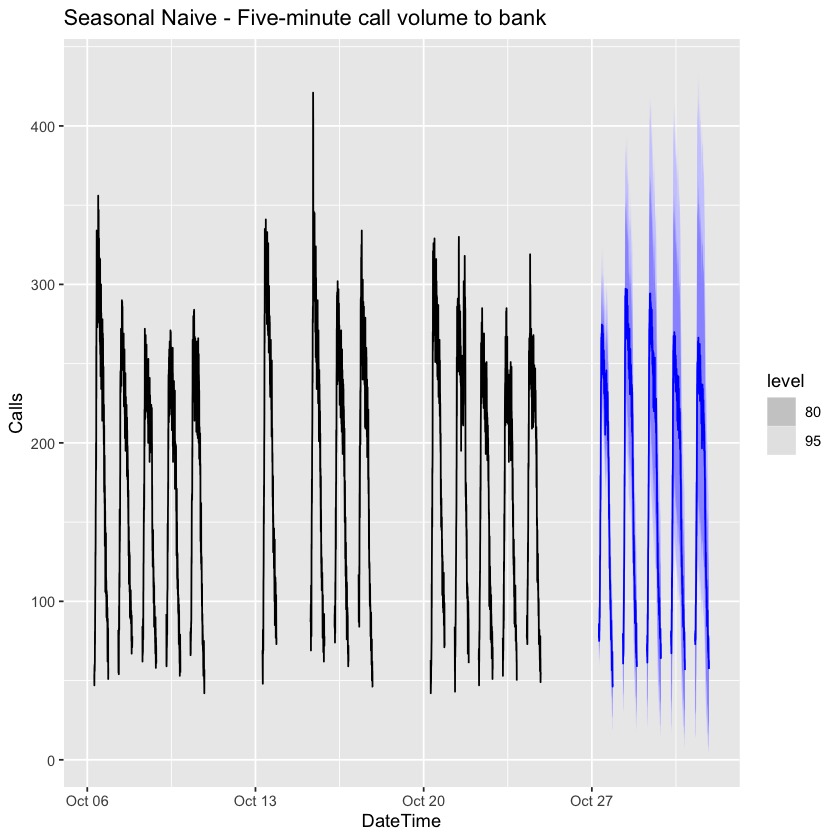

In [9]:
# Plot results with last 3 weeks of data
fc_with_times |>
  fill_gaps() |>
  autoplot(bank_calls |> tail(14 * 169) |> fill_gaps()) +
  labs(y = "Calls",
       title = "Seasonal Naive - Five-minute call volume to bank")

ggsave(paste(plot_prefix, 'bank_calls_seasonal_naive.png', sep=''), height = 3, width = 5)

#### Forecasting usign Fourier Transformations
This will take signficantly longer due to the optimization around the ARIMA terms.

In [10]:
fit <- calls |>
  model(
    dhr = ARIMA(sqrt(Calls) ~ PDQ(0, 0, 0) + pdq(d = 0) +
                  fourier(period = 169, K = 10) +
                  fourier(period = 5*169, K = 5)))

fc <- fit |> forecast(h = 5 * 169)

# Add correct time stamps to fable
fc_with_times <- bank_calls |>
  new_data(n = 7 * 24 * 60 / 5) |>
  mutate(time = format(DateTime, format = "%H:%M:%S")) |>
  filter(
    time %in% format(bank_calls$DateTime, format = "%H:%M:%S"),
    wday(DateTime, week_start = 1) <= 5
  ) |>
  mutate(t = row_number() + max(calls$t)) |>
  left_join(fc, by = "t") |>
  as_fable(response = "Calls", distribution = Calls)

fc_with_times %>% head()

Warning message:
"Provided exogenous regressors are rank deficient, removing regressors: `fourier(period = 5 * 169, K = 5)C5_845`, `fourier(period = 5 * 169, K = 5)S5_845`"


DateTime,time,t,.model,Calls,.mean
<dttm>,<chr>,<dbl>,<chr>,<dist>,<dbl>
2003-10-27 07:00:00,07:00:00,27717,dhr,"t(N(7.5, 0.32))",56.67854
2003-10-27 07:05:00,07:05:00,27718,dhr,"t(N(7.5, 0.35))",57.09438
2003-10-27 07:10:00,07:10:00,27719,dhr,"t(N(7.6, 0.36))",57.73472
2003-10-27 07:15:00,07:15:00,27720,dhr,"t(N(7.6, 0.37))",58.68887
2003-10-27 07:20:00,07:20:00,27721,dhr,"t(N(7.7, 0.38))",60.13731
2003-10-27 07:25:00,07:25:00,27722,dhr,"t(N(7.9, 0.39))",62.14822


- ARIMA terms handled in the error (via setting the PDQ to 0).

In [11]:
fit %>% report()

Series: Calls 
Model: LM w/ ARIMA(1,0,3) errors 
Transformation: sqrt(Calls) 

Coefficients:
         ar1      ma1      ma2      ma3  fourier(period = 169, K = 10)C1_169
      0.9871  -0.7253  -0.0415  -0.0321                              -3.1438
s.e.  0.0011   0.0061   0.0075   0.0060                               0.0252
      fourier(period = 169, K = 10)S1_169  fourier(period = 169, K = 10)C2_169
                                   1.9775                              -1.3323
s.e.                               0.0253                               0.0138
      fourier(period = 169, K = 10)S2_169  fourier(period = 169, K = 10)C3_169
                                   0.6322                              -0.4468
s.e.                               0.0139                               0.0100
      fourier(period = 169, K = 10)S3_169  fourier(period = 169, K = 10)C4_169
                                  -0.3943                              -0.1932
s.e.                               0.0100   

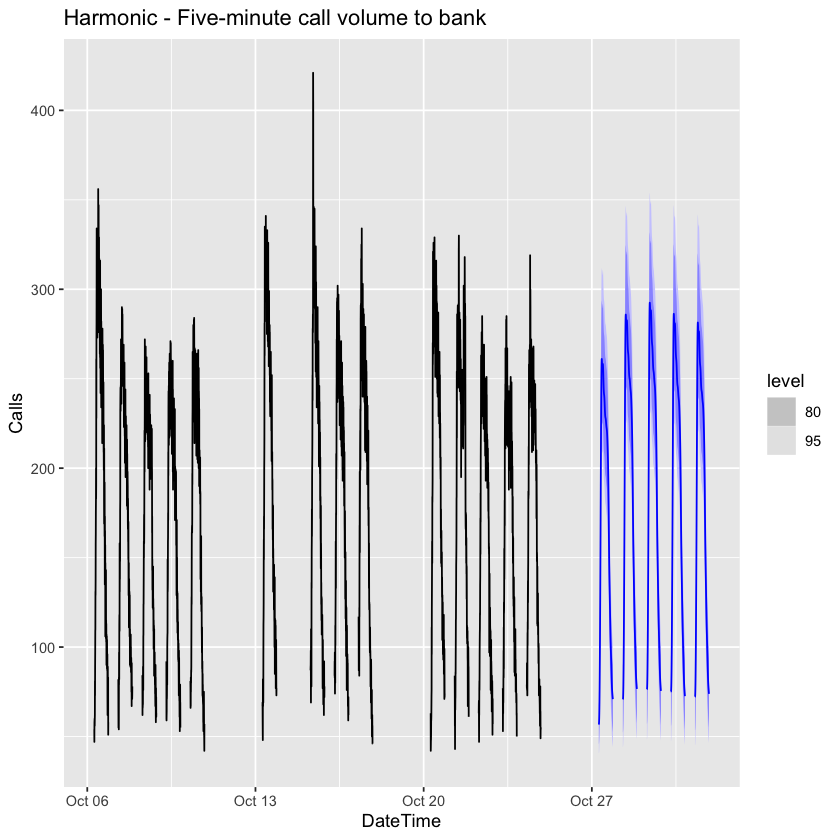

In [12]:
# Plot results with last 3 weeks of data
fc_with_times |>
  fill_gaps() |>
  autoplot(bank_calls |> tail(14 * 169) |> fill_gaps()) +
  labs(y = "Calls",
       title = "Harmonic - Five-minute call volume to bank")

ggsave(paste(plot_prefix, 'bank_calls_harmonic.png', sep=''), height = 3, width = 5)

### Electricity Demand
Another common application, with this example data in half-hour increments, measuring electricity demand.

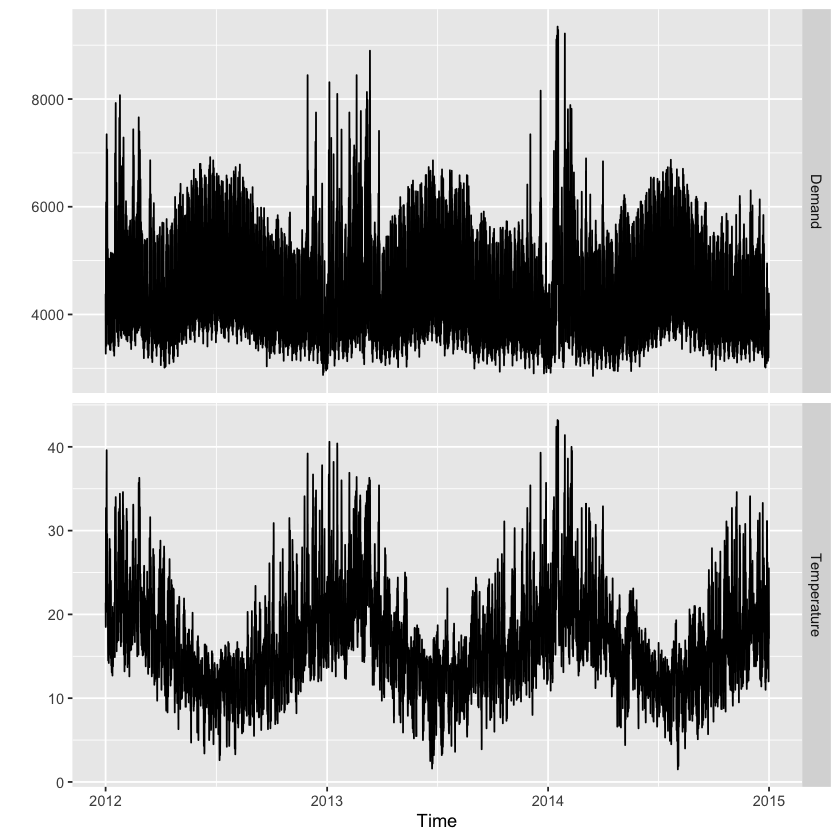

In [21]:
vic_elec |>
  pivot_longer(Demand:Temperature, names_to = "Series") |>
  ggplot(aes(x = Time, y = value)) +
  geom_line() +
  facet_grid(rows = vars(Series), scales = "free_y") +
  labs(y = "")

ggsave(paste(plot_prefix, 'elect_demand_temp.png', sep=''), height = 6, width = 5)

In [14]:
vic_elec %>% head()

Time,Demand,Temperature,Date,Holiday
<dttm>,<dbl>,<dbl>,<date>,<lgl>
2012-01-01 00:00:00,4382.825,21.40,2012-01-01,TRUE
2012-01-01 00:30:00,4263.366,21.05,2012-01-01,TRUE
2012-01-01 01:00:00,4048.966,20.70,2012-01-01,TRUE
2012-01-01 01:30:00,3877.563,20.55,2012-01-01,TRUE
2012-01-01 02:00:00,4036.230,20.40,2012-01-01,TRUE
2012-01-01 02:30:00,3865.597,20.25,2012-01-01,TRUE


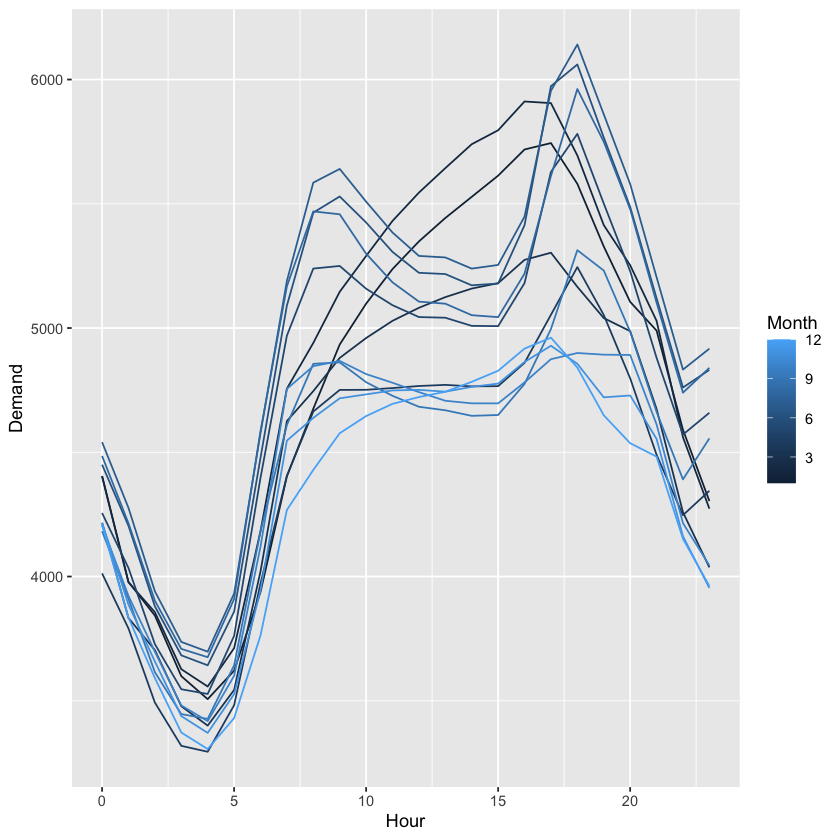

In [22]:
vic_elec %>%
mutate(Hour = hour(Time), Month = month(Time)) %>%
ggplot(aes(x=Hour, y=Demand, colour=Month, group=Month)) + 
stat_summary(fun = mean, geom = "line")

ggsave(paste(plot_prefix, 'elect_demand_monthly_seasonality.png', sep=''), height = 4, width = 5)

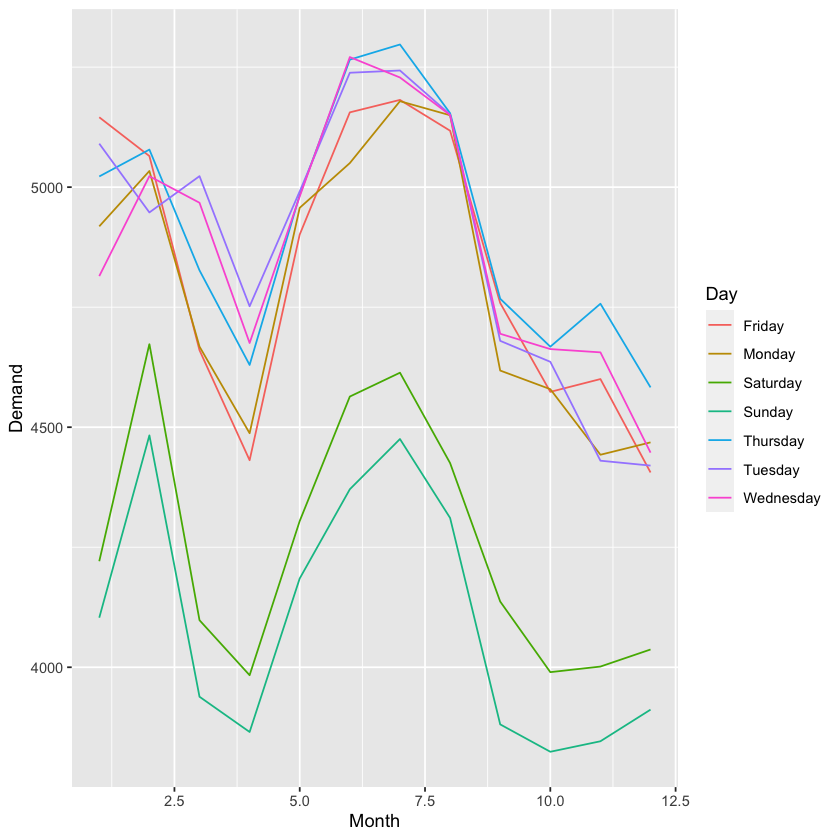

In [23]:
vic_elec %>%
mutate(Month = month(Time), Day = weekdays(Time)) %>%
ggplot(aes(x=Month, y=Demand, colour=Day, group=Day)) + 
stat_summary(fun = mean, geom = "line")

ggsave(paste(plot_prefix, 'elect_demand_daily_seasonality.png', sep=''), height = 4, width = 5)

Non-linear relationship with Temperature

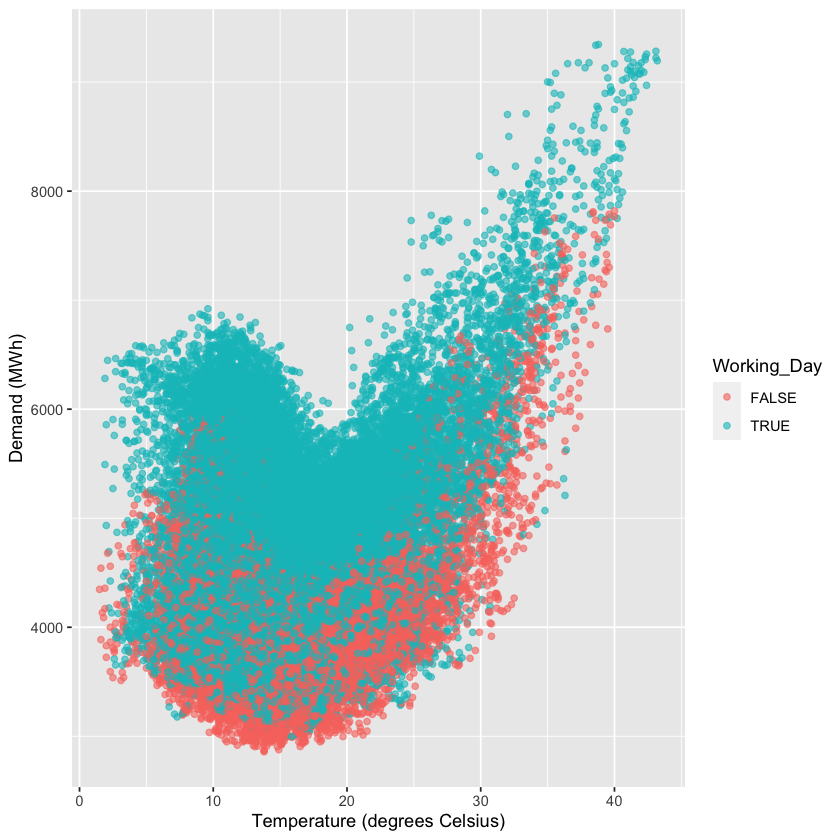

In [24]:
elec <- vic_elec |>
  mutate(
    DOW = wday(Date, label = TRUE),
    Working_Day = !Holiday & !(DOW %in% c("Sat", "Sun")),
    Cooling = pmax(Temperature, 18)
  )
elec |>
  ggplot(aes(x=Temperature, y=Demand, col=Working_Day)) +
  geom_point(alpha = 0.6) +
  labs(x="Temperature (degrees Celsius)", y="Demand (MWh)")

  ggsave(paste(plot_prefix, 'elect_demand_scatter.png', sep=''), height = 6, width = 7)

Cooling variable is the max of either 18 or temperature, acts as a piecewise linear component.

In [18]:
fit <- elec |>
  model(
    ARIMA(Demand ~ PDQ(0, 0, 0) + pdq(d = 0) +
          Temperature + Cooling + Working_Day +
          fourier(period = "day", K = 10) +
          fourier(period = "week", K = 5) +
          fourier(period = "year", K = 3))
  )

  fit %>% report()

Series: Demand 
Model: LM w/ ARIMA(1,0,5) errors 

Coefficients:
         ar1     ma1     ma2     ma3     ma4     ma5  Temperature  Cooling
      0.9258  0.6653  0.3209  0.3094  0.2354  0.0114      -9.0508  19.6214
s.e.  0.0021  0.0051  0.0064  0.0067  0.0059  0.0047       0.8467   1.1121
      Working_DayTRUE  fourier(period = "day", K = 10)C1_48
               0.4319                              235.2615
s.e.           3.4543                                7.9021
      fourier(period = "day", K = 10)S1_48
                                  708.8534
s.e.                                8.0940
      fourier(period = "day", K = 10)C2_48
                                  221.4974
s.e.                                4.2041
      fourier(period = "day", K = 10)S2_48
                                 -243.5861
s.e.                                4.2169
      fourier(period = "day", K = 10)C3_48
                                   57.2103
s.e.                                2.6534
      fourier(

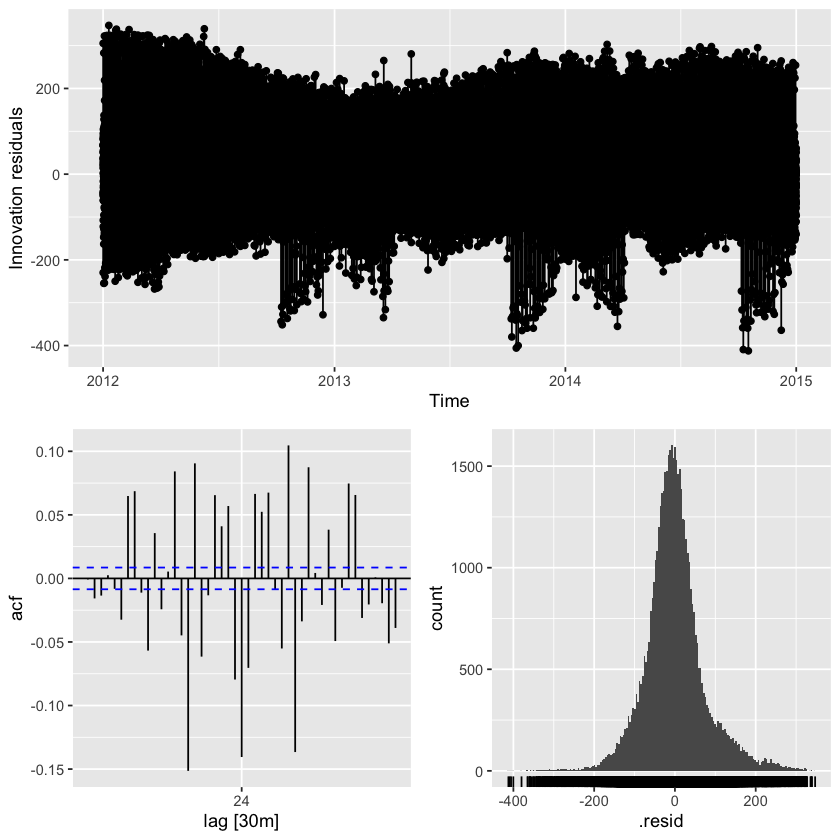

In [27]:
elec_fit_resid_plot <- fit |> gg_tsresiduals()
elec_fit_resid_plot
ggsave(paste(plot_prefix, 'elect_demand_resid.png', sep=''), plot=elec_fit_resid_plot, height = 6, width = 10)

- Numerous spikes in the autocorrelations, indicating there is a lot of information not captured.
- For forecasting, we will use the past 2 days of temperature readings, however, those could also come from a separate service. The prediction internals will be less useful since the uncertainty around the temperature forecasts is not accounted for in the model. In the case of weather, since the temperature foreccasts are quite good in the near-term, the prediction intervals will be imperfect but likely reliable.

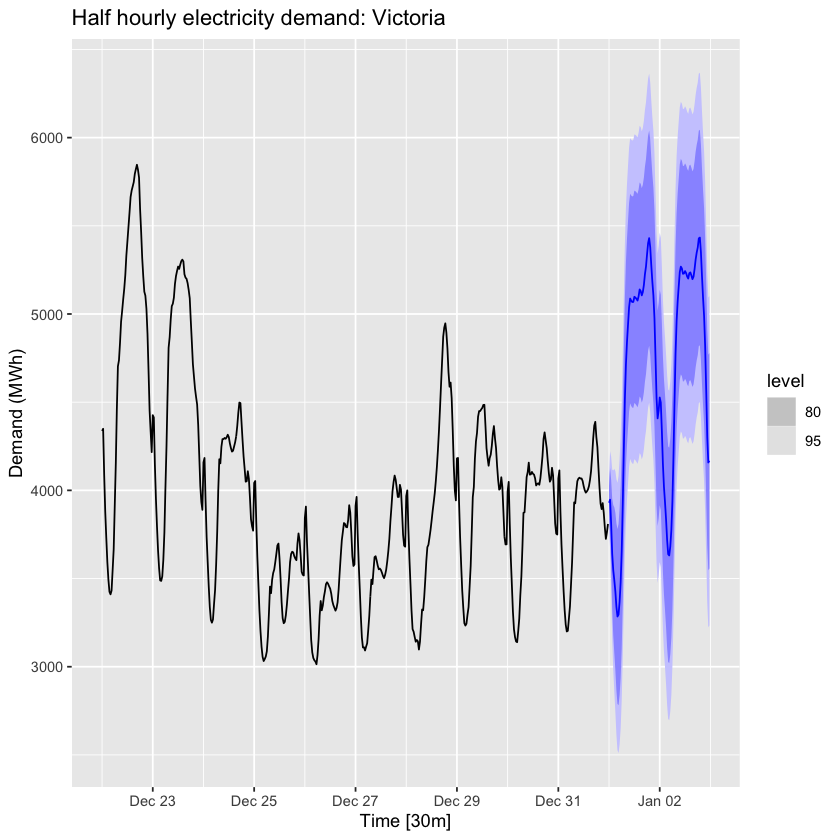

In [26]:
elec_newdata <- new_data(elec, 2*48) |>
  mutate(
    Temperature = tail(elec$Temperature, 2 * 48),
    Date = lubridate::as_date(Time),
    DOW = wday(Date, label = TRUE),
    Working_Day = (Date != "2015-01-01") &
                   !(DOW %in% c("Sat", "Sun")),
    Cooling = pmax(Temperature, 18)
  )
fc <- fit |>
  forecast(new_data = elec_newdata)

fc |>
  autoplot(elec |> tail(10 * 48)) +
  labs(title="Half hourly electricity demand: Victoria",
       y = "Demand (MWh)", x = "Time [30m]")

ggsave(paste(plot_prefix, 'elect_demand_forecasts.png', sep=''), height = 3, width = 6)